In [1]:
import os
import sys
sys.path.append("./ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
from utils.bernstein import bernstein_coeff_order10_new
from ddn.ddn.pytorch.node import AbstractDeclarativeNode
from utils.models.ddn import *
from utils.nodes.OPTNode import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
rho_obs = 1.2
rho_eq = 10.0
weight_smoothness = 10

pred_len = 30
num = 30
t_fin = 2.0
a_obs = 1.0
b_obs = 1.0

tot_time = np.linspace(0.0, t_fin, num)
tot_time_copy = tot_time.reshape(num, 1)
P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
nvar = np.shape(P)[1]

x_obs_temp = np.hstack((-10000.0, 10000.79, 30000.0, 10000.0))
y_obs_temp = np.hstack((-10000.0, 10000.0, -30000.80, 10000.0))

num_obs = np.shape(x_obs_temp)[0]

x_obs = np.ones((num_obs, num)) * x_obs_temp[:, np.newaxis]
y_obs = np.ones((num_obs, num)) * y_obs_temp[:, np.newaxis]

obs_inp_list = []
for i in range(num_obs):
    obs_inp_list.extend([x_obs_temp[i], y_obs_temp[i], a_obs])
    
A_obs = np.tile(P, (num_obs, 1))
A_eq = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))
Q_smoothness = np.dot(Pddot.T, Pddot)

In [129]:
#####################################################
#####################################################
##################### NEW OPTIMIZER #################
#######################################################
######################################################
class OPTNode2(AbstractDeclarativeNode):
    def __init__(self, rho_eq=1.0, rho_goal=1.0, rho_nonhol=1.0, rho_psi=1.0, maxiter=5000, weight_smoothness=1.0, weight_smoothness_psi=1.0, t_fin=2.0, num=30, bernstein_coeff_order10_new=None, device="cpu"):
        super().__init__()
        self.rho_eq = rho_eq
        self.rho_goal = rho_goal
        self.rho_nonhol = rho_nonhol
        self.rho_psi = rho_psi
        self.maxiter = maxiter
        self.weight_smoothness = weight_smoothness
        self.weight_smoothness_psi = weight_smoothness_psi
        self.bernstein_coeff_order10_new = bernstein_coeff_order10_new
        
        self.device = device
        
        self.t_fin = t_fin
        self.num = num
        self.t = self.t_fin / self.num

        #self.num_batch = 10
        
        tot_time = np.linspace(0.0, self.t_fin, self.num)
        tot_time_copy = tot_time.reshape(self.num, 1)
        self.P, self.Pdot, self.Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
        self.nvar = np.shape(self.P)[1]
        
        self.cost_smoothness = self.weight_smoothness * np.dot(self.Pddot.T, self.Pddot)
        self.cost_smoothness_psi = self.weight_smoothness_psi * np.dot(self.Pddot.T, self.Pddot)
        self.lincost_smoothness_psi = np.zeros(self.nvar)

        self.A_eq = np.vstack((self.P[0], self.P[-1]))
        self.A_eq_psi = np.vstack((self.P[0], self.Pdot[0], self.P[-1]))
        
        self.P = torch.tensor(self.P, dtype=torch.double).to(device)
        self.Pdot = torch.tensor(self.Pdot, dtype=torch.double).to(device)
        self.Pddot = torch.tensor(self.Pddot, dtype=torch.double).to(device)
        self.A_eq = torch.tensor(self.A_eq, dtype=torch.double).to(device)        
        self.A_eq_psi = torch.tensor(self.A_eq_psi, dtype=torch.double).to(device)
        self.cost_smoothness = torch.tensor(self.cost_smoothness, dtype=torch.double).to(device)
        self.cost_smoothness_psi = torch.tensor(self.cost_smoothness_psi, dtype=torch.double).to(device)
        self.lincost_smoothness_psi = torch.tensor(self.lincost_smoothness_psi, dtype=torch.double).to(device)
    
        self.A_nonhol = self.Pdot
        self.A_psi = self.P
        
        self.lamda_x = None
        self.lamda_y = None
        self.lamda_psi = None
        
    def compute_x(self, v, psi, b_eq_x, b_eq_y):
        b_nonhol_x = v * torch.cos(psi)
        b_nonhol_y = v * torch.sin(psi)
    
        cost = self.cost_smoothness + self.rho_nonhol * torch.matmul(self.A_nonhol.T, self.A_nonhol) + self.rho_eq * torch.matmul(self.A_eq.T, self.A_eq)
        lincost_x = -self.lamda_x - self.rho_nonhol * torch.matmul(self.A_nonhol.T, b_nonhol_x.T).T - self.rho_eq * torch.matmul(self.A_eq.T, b_eq_x.T).T
        lincost_y = -self.lamda_y - self.rho_nonhol * torch.matmul(self.A_nonhol.T, b_nonhol_y.T).T - self.rho_eq * torch.matmul(self.A_eq.T, b_eq_y.T).T

        cost_inv = torch.linalg.inv(cost)

        sol_x = torch.matmul(-cost_inv, lincost_x.T).T
        sol_y = torch.matmul(-cost_inv, lincost_y.T).T

        x = torch.matmul(self.P, sol_x.T).T
        xdot = torch.matmul(self.Pdot, sol_x.T).T

        y = torch.matmul(self.P, sol_y.T).T
        ydot = torch.matmul(self.Pdot, sol_y.T).T
         
        return sol_x, sol_y, x, xdot, y, ydot
    
    def compute_psi(self, psi, lamda_psi, psi_temp, b_eq_psi):
        cost = self.cost_smoothness_psi + self.rho_psi * torch.matmul(self.A_psi.T, self.A_psi) + self.rho_eq * torch.matmul(self.A_eq_psi.T, self.A_eq_psi)
        lincost_psi = -self.lamda_psi - self.rho_psi * torch.matmul(self.A_psi.T, psi_temp.T).T - self.rho_eq * torch.matmul(self.A_eq_psi.T, b_eq_psi.T).T

        cost_inv = torch.linalg.inv(cost)

        sol_psi = torch.matmul(-cost_inv, lincost_psi.T).T

        psi = torch.matmul(self.P, sol_psi.T).T

        res_psi = torch.matmul(self.A_psi, sol_psi.T).T - psi_temp
        res_eq_psi = torch.matmul(self.A_eq_psi, sol_psi.T).T - b_eq_psi

        self.lamda_psi = self.lamda_psi - self.rho_psi * torch.matmul(self.A_psi.T, res_psi.T).T - self.rho_eq * torch.matmul(self.A_eq_psi.T, res_eq_psi.T).T

        return sol_psi, torch.linalg.norm(res_psi), torch.linalg.norm(res_eq_psi), psi

    
    def solve(self, fixed_params, variable_params):
        batch_size, _ = fixed_params.size()
        x_init, y_init, v_init, psi_init, psidot_init = torch.chunk(fixed_params, 5, dim=1)
        x_fin, y_fin, psi_fin = torch.chunk(variable_params, 3, dim=1)
        
        b_eq_x = torch.cat((x_init, x_fin), dim=1)
        b_eq_y = torch.cat((y_init, y_fin), dim=1)
        b_eq_psi = torch.cat((psi_init, psidot_init, psi_fin), dim=1)
        
        v = torch.ones(batch_size, self.num, dtype=torch.double).to(self.device) * v_init
        psi = torch.ones(batch_size, self.num, dtype=torch.double).to(self.device) * psi_init
        xdot = v * torch.cos(psi)
        ydot = v * torch.sin(psi)
        
        self.lamda_x = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(self.device)
        self.lamda_y = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(self.device)
        self.lamda_psi = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(self.device)
        
        res_psi_arr = []
        res_eq_psi_arr = []
        res_eq_arr = []
        res_nonhol_arr = []
        for i in range(0, self.maxiter):
            psi_temp = torch.atan2(ydot, xdot)
            c_psi, res_psi, res_eq_psi, psi = self.compute_psi(psi, self.lamda_psi, psi_temp, b_eq_psi)
            c_x, c_y, x, xdot, y, ydot = self.compute_x(v, psi, b_eq_x, b_eq_y)
            
            res_eq_psi_arr.append(res_eq_psi)
            res_psi_arr.append(res_psi)
            v = torch.sqrt(xdot ** 2 + ydot ** 2)
            #v[:, 0] = v_init[:, 0]

            res_eq_x = torch.matmul(self.A_eq, c_x.T).T - b_eq_x
            res_nonhol_x = xdot - v * torch.cos(psi)

            res_eq_y = torch.matmul(self.A_eq, c_y.T).T - b_eq_y
            res_nonhol_y = ydot - v * torch.sin(psi)

            res_eq_arr.append(torch.linalg.norm(torch.sqrt(res_eq_x**2 + res_eq_y**2)))
            res_nonhol_arr.append(torch.linalg.norm(torch.sqrt(res_nonhol_x**2 + res_nonhol_y**2)))
            
            self.lamda_x = self.lamda_x - self.rho_eq * torch.matmul(self.A_eq.T, res_eq_x.T).T - self.rho_nonhol * torch.matmul(self.A_nonhol.T, res_nonhol_x.T).T
            self.lamda_y = self.lamda_y - self.rho_eq * torch.matmul(self.A_eq.T, res_eq_y.T).T - self.rho_nonhol * torch.matmul(self.A_nonhol.T, res_nonhol_y.T).T
        
        primal_sol = torch.hstack((c_x, c_y, c_psi, v))
        return primal_sol, None
    
    def objective(self, fixed_params, variable_params, y):
        c_x = y[:, :self.nvar]
        c_y = y[:, self.nvar:2*self.nvar]
        c_psi = y[:, 2*self.nvar:3*self.nvar]
        v = y[:, 3*self.nvar:]
        
        x_init, y_init, v_init, psi_init, psidot_init = torch.chunk(fixed_params, 5, dim=1)
        x_fin, y_fin, psi_fin = torch.chunk(variable_params, 3, dim=1)
        
        x = torch.matmul(self.P, c_x.T).T
        y = torch.matmul(self.P, c_y.T).T
        psi = torch.matmul(self.P, c_psi.T).T
        xdot = torch.matmul(self.Pdot, c_x.T).T
        ydot = torch.matmul(self.Pdot, c_y.T).T
        psidot = torch.matmul(self.Pdot, c_psi.T).T
        xddot = torch.matmul(self.Pddot, c_x.T).T
        yddot = torch.matmul(self.Pddot, c_y.T).T
        psiddot = torch.matmul(self.Pddot, c_psi.T).T
        
        cost_nonhol = 0.5*self.rho_nonhol*torch.sum((xdot - v*torch.cos(psi)) ** 2, 1) + 0.5*self.rho_nonhol*torch.sum((ydot - v*torch.sin(psi)) ** 2, 1)
        cost_pos = 0.5*self.rho_eq*(torch.sum((x[:, -1] - x_fin) ** 2, 1) + torch.sum((y[:, -1] - y_fin) ** 2, 1) + torch.sum((x[:, 0] - x_init) ** 2, 1) + torch.sum((y[:, 0] - y_init) ** 2, 1))
        cost_psi = 0.5*self.rho_eq*(torch.sum((psi[:, -1] - psi_fin) ** 2, 1) + torch.sum((psi[:, 0] - psi_init) ** 2, 1)
                                    + torch.sum((psidot[:, 0] - psidot_init) ** 2, 1))
        #cost_v = 0.5*self.rho_eq*torch.sum((v[:, 0] - v_init) ** 2, 1)
        cost_cancel = torch.diagonal(torch.matmul(-self.lamda_x, c_x.T) + torch.matmul(-self.lamda_y, c_y.T) + torch.matmul(-self.lamda_psi, c_psi.T))
        
        cost_smoothness = 0.5*self.weight_smoothness*(torch.sum(xddot**2, 1) + torch.sum(yddot**2, 1)) + 0.5*self.weight_smoothness_psi*torch.sum(psiddot**2, 1)
        return cost_nonhol + cost_pos + cost_psi + cost_smoothness + cost_cancel #+ cost_v 


In [132]:
#####################################################
#####################################################
##################### NEW OPTIMIZER #################
#######################################################
######################################################
class OPTNode(AbstractDeclarativeNode):
    def __init__(self, rho_eq=1.0, rho_goal=1.0, a_obs=1.0, b_obs=1.0, x_obs=[], y_obs=[], rho_obs=3.0, num_obs=0, rho_nonhol=1.0, rho_psi=1.0, maxiter=5000, weight_smoothness=1.0, weight_smoothness_psi=1.0, t_fin=2.0, num=30, bernstein_coeff_order10_new=None, device="cpu"):
        super().__init__()
        self.rho_eq = rho_eq
        self.rho_goal = rho_goal
        self.rho_nonhol = rho_nonhol
        self.rho_psi = rho_psi
        self.rho_obs = rho_obs
        self.maxiter = maxiter
        self.a_obs = a_obs
        self.b_obs = b_obs
        self.x_obs = torch.tensor(x_obs, dtype=torch.double).to(device)
        self.y_obs = torch.tensor(y_obs, dtype=torch.double).to(device)
        self.num_obs = num_obs
        self.weight_smoothness = weight_smoothness
        self.weight_smoothness_psi = weight_smoothness_psi
        self.bernstein_coeff_order10_new = bernstein_coeff_order10_new
        
        self.device = device
        
        self.t_fin = t_fin
        self.num = num
        self.t = self.t_fin / self.num

        #self.num_batch = 10
        
        tot_time = np.linspace(0.0, self.t_fin, self.num)
        tot_time_copy = tot_time.reshape(self.num, 1)
        self.P, self.Pdot, self.Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
        self.nvar = np.shape(self.P)[1]
        
        self.cost_smoothness = self.weight_smoothness * np.dot(self.Pddot.T, self.Pddot)
        self.cost_smoothness_psi = self.weight_smoothness_psi * np.dot(self.Pddot.T, self.Pddot)
        self.lincost_smoothness_psi = np.zeros(self.nvar)

        self.A_eq = np.vstack((self.P[0], self.P[-1]))
        self.A_obs = np.tile(self.P, (num_obs, 1))
        self.A_eq_psi = np.vstack((self.P[0], self.Pdot[0], self.P[-1]))
        
        self.P = torch.tensor(self.P, dtype=torch.double).to(device)
        self.Pdot = torch.tensor(self.Pdot, dtype=torch.double).to(device)
        self.Pddot = torch.tensor(self.Pddot, dtype=torch.double).to(device)
        self.A_obs = torch.tensor(self.A_obs, dtype=torch.double).to(device)
        self.A_eq = torch.tensor(self.A_eq, dtype=torch.double).to(device)        
        self.A_eq_psi = torch.tensor(self.A_eq_psi, dtype=torch.double).to(device)
        self.cost_smoothness = torch.tensor(self.cost_smoothness, dtype=torch.double).to(device)
        self.cost_smoothness_psi = torch.tensor(self.cost_smoothness_psi, dtype=torch.double).to(device)
        self.lincost_smoothness_psi = torch.tensor(self.lincost_smoothness_psi, dtype=torch.double).to(device)
    
        self.A_nonhol = self.Pdot
        self.A_psi = self.P
        
        self.lamda_x = None
        self.lamda_y = None
        self.lamda_psi = None
        
    def compute_x(self, v, psi, b_eq_x, b_eq_y):
        b_nonhol_x = v * torch.cos(psi)
        b_nonhol_y = v * torch.sin(psi)
    
        b_obs_x = self.x_obs.view(self.num * self.num_obs) + self.temp_x_obs.view(self.num * self.num_obs)
        b_obs_y = self.y_obs.view(self.num * self.num_obs) + self.temp_y_obs.view(self.num * self.num_obs)
    
        cost = self.cost_smoothness + self.rho_nonhol * torch.matmul(self.A_nonhol.T, self.A_nonhol) + self.rho_eq * torch.matmul(self.A_eq.T, self.A_eq) + self.rho_obs * torch.matmul(self.A_obs.T, self.A_obs)
        lincost_x = -self.lamda_x - self.rho_nonhol * torch.matmul(self.A_nonhol.T, b_nonhol_x.T).T - self.rho_eq * torch.matmul(self.A_eq.T, b_eq_x.T).T - self.rho_obs * torch.matmul(self.A_obs.T, b_obs_x)
        lincost_y = -self.lamda_y - self.rho_nonhol * torch.matmul(self.A_nonhol.T, b_nonhol_y.T).T - self.rho_eq * torch.matmul(self.A_eq.T, b_eq_y.T).T - self.rho_obs * torch.matmul(self.A_obs.T, b_obs_y)

        cost_inv = torch.linalg.inv(cost)

        sol_x = torch.matmul(-cost_inv, lincost_x.T).T
        sol_y = torch.matmul(-cost_inv, lincost_y.T).T

        x = torch.matmul(self.P, sol_x.T).T
        xdot = torch.matmul(self.Pdot, sol_x.T).T

        y = torch.matmul(self.P, sol_y.T).T
        ydot = torch.matmul(self.Pdot, sol_y.T).T
         
        return sol_x, sol_y, x, xdot, y, ydot
    
    def compute_psi(self, psi, lamda_psi, psi_temp, b_eq_psi):
        cost = self.cost_smoothness_psi + self.rho_psi * torch.matmul(self.A_psi.T, self.A_psi) + self.rho_eq * torch.matmul(self.A_eq_psi.T, self.A_eq_psi)
        lincost_psi = -self.lamda_psi - self.rho_psi * torch.matmul(self.A_psi.T, psi_temp.T).T - self.rho_eq * torch.matmul(self.A_eq_psi.T, b_eq_psi.T).T

        cost_inv = torch.linalg.inv(cost)

        sol_psi = torch.matmul(-cost_inv, lincost_psi.T).T

        psi = torch.matmul(self.P, sol_psi.T).T

        res_psi = torch.matmul(self.A_psi, sol_psi.T).T - psi_temp
        res_eq_psi = torch.matmul(self.A_eq_psi, sol_psi.T).T - b_eq_psi

        self.lamda_psi = self.lamda_psi - self.rho_psi * torch.matmul(self.A_psi.T, res_psi.T).T - self.rho_eq * torch.matmul(self.A_eq_psi.T, res_eq_psi.T).T

        return sol_psi, torch.linalg.norm(res_psi), torch.linalg.norm(res_eq_psi), psi

    
    def solve(self, fixed_params, variable_params):
        batch_size, _ = fixed_params.size()
        x_init, y_init, v_init, psi_init, psidot_init = torch.chunk(fixed_params, 5, dim=1)
        x_fin, y_fin, psi_fin = torch.chunk(variable_params, 3, dim=1)
        
        b_eq_x = torch.cat((x_init, x_fin), dim=1)
        b_eq_y = torch.cat((y_init, y_fin), dim=1)
        b_eq_psi = torch.cat((psi_init, psidot_init, psi_fin), dim=1)

        d_obs = torch.ones(self.num_obs, self.num, dtype=torch.double).to(device)
        alpha_obs = torch.zeros(self.num_obs, self.num, dtype=torch.double).to(device)
        ones_tensor = torch.ones((self.num_obs, self.num), dtype=torch.double).to(device)        
        
        v = torch.ones(batch_size, self.num, dtype=torch.double).to(self.device) * v_init
        psi = torch.ones(batch_size, self.num, dtype=torch.double).to(self.device) * psi_init
        xdot = v * torch.cos(psi)
        ydot = v * torch.sin(psi)
        
        self.lamda_x = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(self.device)
        self.lamda_y = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(self.device)
        self.lamda_psi = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(self.device)
        
        res_psi_arr = []
        res_eq_psi_arr = []
        res_eq_arr = []
        res_nonhol_arr = []
        for i in range(0, self.maxiter):
            self.temp_x_obs = d_obs * torch.cos(alpha_obs) * self.a_obs
            self.temp_y_obs = d_obs * torch.sin(alpha_obs) * self.b_obs

            psi_temp = torch.atan2(ydot, xdot)
            c_psi, res_psi, res_eq_psi, psi = self.compute_psi(psi, self.lamda_psi, psi_temp, b_eq_psi)
            c_x, c_y, x, xdot, y, ydot = self.compute_x(v, psi, b_eq_x, b_eq_y)
            
            wc_alpha = x - self.x_obs
            ws_alpha = y - self.y_obs
            alpha_obs = torch.atan2(ws_alpha * self.a_obs, wc_alpha * self.b_obs)

            c1_d = self.rho_obs * (self.a_obs ** 2 * torch.cos(alpha_obs) ** 2 + self.b_obs ** 2 * torch.sin(alpha_obs) ** 2)
            c2_d = self.rho_obs * (self.a_obs * wc_alpha * torch.cos(alpha_obs) + self.b_obs * ws_alpha * torch.sin(alpha_obs))
            d_temp = c2_d / c1_d
            d_obs = torch.max(d_temp, ones_tensor)
            
            res_x_obs_vec = wc_alpha - self.a_obs * d_obs * torch.cos(alpha_obs)
            res_y_obs_vec = ws_alpha - self.b_obs * d_obs * torch.sin(alpha_obs)            
            
            res_eq_psi_arr.append(res_eq_psi)
            res_psi_arr.append(res_psi)
            v = torch.sqrt(xdot ** 2 + ydot ** 2)
            #v[:, 0] = v_init[:, 0]

            res_eq_x = torch.matmul(self.A_eq, c_x.T).T - b_eq_x
            res_nonhol_x = xdot - v * torch.cos(psi)

            res_eq_y = torch.matmul(self.A_eq, c_y.T).T - b_eq_y
            res_nonhol_y = ydot - v * torch.sin(psi)

            res_eq_arr.append(torch.linalg.norm(torch.sqrt(res_eq_x**2 + res_eq_y**2)))
            res_nonhol_arr.append(torch.linalg.norm(torch.sqrt(res_nonhol_x**2 + res_nonhol_y**2)))
            
            self.lamda_x = self.lamda_x - self.rho_eq * torch.matmul(self.A_eq.T, res_eq_x.T).T - self.rho_nonhol * torch.matmul(self.A_nonhol.T, res_nonhol_x.T).T - self.rho_obs * torch.matmul(self.A_obs.T, res_x_obs_vec.view(-1))
            self.lamda_y = self.lamda_y - self.rho_eq * torch.matmul(self.A_eq.T, res_eq_y.T).T - self.rho_nonhol * torch.matmul(self.A_nonhol.T, res_nonhol_y.T).T - self.rho_obs * torch.matmul(self.A_obs.T, res_y_obs_vec.view(-1))
        
        primal_sol = torch.hstack((c_x, c_y, c_psi, v))
        return primal_sol, None
    
    def objective(self, fixed_params, variable_params, y):
        c_x = y[:, :self.nvar]
        c_y = y[:, self.nvar:2*self.nvar]
        c_psi = y[:, 2*self.nvar:3*self.nvar]
        v = y[:, 3*self.nvar:]        
        
        x_init, y_init, v_init, psi_init, psidot_init = torch.chunk(fixed_params, 5, dim=1)
        x_fin, y_fin, psi_fin = torch.chunk(variable_params, 3, dim=1)
        
        x = torch.matmul(self.P, c_x.T).T
        y = torch.matmul(self.P, c_y.T).T
        psi = torch.matmul(self.P, c_psi.T).T
        xdot = torch.matmul(self.Pdot, c_x.T).T
        ydot = torch.matmul(self.Pdot, c_y.T).T
        psidot = torch.matmul(self.Pdot, c_psi.T).T
        xddot = torch.matmul(self.Pddot, c_x.T).T
        yddot = torch.matmul(self.Pddot, c_y.T).T
        psiddot = torch.matmul(self.Pddot, c_psi.T).T
        
        cost_nonhol = 0.5*self.rho_nonhol*torch.sum((xdot - v*torch.cos(psi)) ** 2, 1) + 0.5*self.rho_nonhol*torch.sum((ydot - v*torch.sin(psi)) ** 2, 1)
        cost_pos = 0.5*self.rho_eq*(torch.sum((x[:, -1] - x_fin) ** 2, 1) + torch.sum((y[:, -1] - y_fin) ** 2, 1) + torch.sum((x[:, 0] - x_init) ** 2, 1) + torch.sum((y[:, 0] - y_init) ** 2, 1))
        cost_psi = 0.5*self.rho_eq*(torch.sum((psi[:, -1] - psi_fin) ** 2, 1) + torch.sum((psi[:, 0] - psi_init) ** 2, 1)
                                    + torch.sum((psidot[:, 0] - psidot_init) ** 2, 1))
        #cost_v = 0.5*self.rho_eq*torch.sum((v[:, 0] - v_init) ** 2, 1)
        cost_cancel = torch.diagonal(torch.matmul(-self.lamda_x, c_x.T) + torch.matmul(-self.lamda_y, c_y.T) + torch.matmul(-self.lamda_psi, c_psi.T))
        
        cost_smoothness = 0.5*self.weight_smoothness*(torch.sum(xddot**2, 1) + torch.sum(yddot**2, 1)) + 0.5*self.weight_smoothness_psi*torch.sum(psiddot**2, 1)
        return cost_nonhol + cost_pos + cost_psi + cost_smoothness + cost_cancel #+ cost_v 


In [146]:
for i in range(100):
    x_init, y_init, v_init, psi_init, psidot_init = 0.0, 0.0, 0.0, 0.0, 0.0
    x_fin, y_fin, psi_fin = 30  + np.random.rand() * 70, -3 + np.random.rand() * 5, 0.0
    # sol = problem.solve(fixed_params, variable_params)
    device = "cpu"

    num_obs = np.random.randint(1, 5)
    x_obs = []
    y_obs = []
    for j in range(num_obs):        
        x_obs.append(5 + np.random.rand() * x_fin)
        y_obs.append(-2 + np.random.rand() * 2)
    x_obs = np.array(x_obs)
    y_obs = np.array(y_obs)
    a_obs = 3.0
    b_obs = 3.0
    rho_obs = 1.0

    x_obs = np.ones((num_obs, num)) * x_obs[:, np.newaxis]
    y_obs = np.ones((num_obs, num)) * y_obs[:, np.newaxis]

    problem = OPTNode(x_obs=x_obs, y_obs=y_obs, a_obs=a_obs, b_obs=b_obs, num_obs=num_obs, rho_obs=rho_obs, rho_eq=10, t_fin=9.0, num=pred_len, bernstein_coeff_order10_new=bernstein_coeff_order10_new, device = "cpu")
    problem2 = OPTNode2(rho_eq=10, t_fin=9.0, num=pred_len, bernstein_coeff_order10_new=bernstein_coeff_order10_new, device = "cpu")
    
    fixed_params = torch.tensor([x_init, y_init, v_init, psi_init, psidot_init], dtype=torch.double).reshape(1, 5)
    variable_params = torch.tensor([x_fin, y_fin, psi_fin], dtype=torch.double).reshape(1, 3)
    sol = problem.solve(fixed_params, variable_params)[0]
    sol2 = problem2.solve(fixed_params, variable_params)[0]
    # Compute final trajectory
    x_pred = torch.matmul(torch.tensor(P), sol[:, :nvar].transpose(0, 1))
    y_pred = torch.matmul(torch.tensor(P), sol[:, nvar:2*nvar].transpose(0, 1))

    x_pred2 = torch.matmul(torch.tensor(P), sol2[:, :nvar].transpose(0, 1))
    y_pred2 = torch.matmul(torch.tensor(P), sol2[:, nvar:2*nvar].transpose(0, 1))
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5)) # note we must use plt.subplots, not plt.subplot
    for ind in range(num_obs):
        circle1 = plt.Circle((x_obs[ind][0], y_obs[ind][0]), a_obs, color='orange')
        ax1.add_patch(circle1)
        circle2 = plt.Circle((x_obs[ind][0], y_obs[ind][0]), a_obs, color='orange')
        ax2.add_patch(circle2)
    ax1.scatter(x_pred, y_pred)
    ax1.set_title("With collision avoidance")
    ax2.scatter(x_pred2, y_pred2)
    ax2.set_title("Without collision avoidance")
    # plt.axis('equal')
    ax1.set_xlim([-20, 100])
    ax1.set_ylim([-50, 50])
    ax2.set_xlim([-20, 100])
    ax2.set_ylim([-50, 50])
    plt.savefig(f"figs/{i}.png")
    plt.clf()

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

torch.Size([30, 11]) RARA


(-3.9999650913160583, 83.99996491092192, -6.924500498475947, 6.61545240468933)

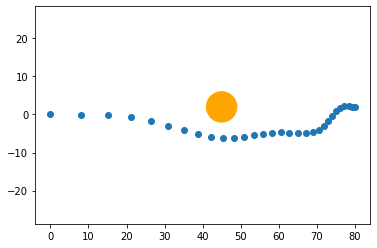

In [ ]:

# plt.scatter()

In [ ]:
#####################################################
#####################################################
##################### OLD OPTIMIZER #################
#######################################################
######################################################

class OPTNode(AbstractDeclarativeNode):
    def __init__(self, P, Pddot, A_eq, A_obs, Q_smoothness, x_obs, y_obs, num=12, num_obs=4, nvar=11, a_obs=1.0, b_obs=1.0, rho_obs=0.3, rho_eq=10.0, weight_smoothness=10, maxiter=300, eps=1e-7, num_tot=48):
        super().__init__()
        self.P = torch.tensor(P, dtype=torch.double).to(device)
        self.Pddot = torch.tensor(Pddot, dtype=torch.double).to(device)
        self.A_eq = torch.tensor(A_eq, dtype=torch.double).to(device)
        self.A_obs = torch.tensor(A_obs, dtype=torch.double).to(device)
        self.Q_smoothness = torch.tensor(Q_smoothness, dtype=torch.double).to(device)
        self.x_obs = torch.tensor(x_obs, dtype=torch.double).to(device)
        self.y_obs = torch.tensor(y_obs, dtype=torch.double).to(device)
        
        self.num = num
        self.num_obs = num_obs
        self.eps = eps
        self.nvar = nvar        
        self.a_obs = a_obs
        self.b_obs = b_obs        
        self.rho_eq = rho_eq
        self.num_obs = num_obs
        self.maxiter = maxiter
        self.num_tot = num_tot
        self.rho_obs = rho_obs
        self.weight_smoothness = weight_smoothness
        
    def objective(self, b, lamda_x, lamda_y, y):  
        batch_size, _ = b.size()
        b = b.transpose(0, 1)
        y = y.transpose(0, 1)
        lamda_x = lamda_x.transpose(0, 1)
        lamda_y = lamda_y.transpose(0, 1)
        bx_eq_tensor, by_eq_tensor = torch.split(b, 6, dim=0)
        ones_tensor = torch.ones(self.num_tot, batch_size, dtype=torch.double).to(device)

        c_x = y[0:self.nvar]
        c_y = y[self.nvar:2 * self.nvar]
        alpha_obs = y[2 * self.nvar: 2 * self.nvar + self.num_tot]
        d_obs = y[2 * self.nvar + self.num_tot:]

        cost_smoothness_x = 0.5 * self.weight_smoothness * torch.diag(torch.matmul(c_x.T, torch.matmul(self.Q_smoothness, c_x)))
        cost_smoothness_y = 0.5 * self.weight_smoothness * torch.diag(torch.matmul(c_y.T, torch.matmul(self.Q_smoothness, c_y)))

        self.temp_x_obs = d_obs * torch.cos(alpha_obs) * self.a_obs
        b_obs_x = self.x_obs.view(-1, 1) + self.temp_x_obs

        self.temp_y_obs = d_obs * torch.sin(alpha_obs) * self.b_obs
        b_obs_y = self.y_obs.view(-1, 1) + self.temp_y_obs

        cost_obs_x = 0.5 * self.rho_obs * (torch.sum((torch.matmul(self.A_obs, c_x) - b_obs_x) ** 2, axis=0))
        cost_obs_y = 0.5 * self.rho_obs * (torch.sum((torch.matmul(self.A_obs, c_y) - b_obs_y) ** 2, axis=0))
        cost_slack = self.rho_obs * torch.sum(torch.max(1 - d_obs, ones_tensor), axis=0)

        cost_eq_x = 0.5 * self.rho_eq * torch.sum((torch.matmul(self.A_eq, c_x) - bx_eq_tensor) ** 2, axis=0)
        cost_eq_y = 0.5 * self.rho_eq * torch.sum((torch.matmul(self. A_eq, c_y) - by_eq_tensor) ** 2, axis=0)

        cost_x = cost_smoothness_x + cost_obs_x + cost_eq_x - torch.diag(torch.matmul(lamda_x.transpose(0, 1), c_x))
        cost_y = cost_smoothness_y + cost_obs_y + cost_eq_y - torch.diag(torch.matmul(lamda_y.transpose(0, 1), c_y))
        cost = cost_x + cost_y + self.eps * torch.sum(c_x ** 2, axis=0) + self.eps * torch.sum(c_y ** 2, axis=0) + self.eps * torch.sum(d_obs ** 2, axis=0) + self.eps * torch.sum(alpha_obs ** 2, axis=0) + cost_slack
        return cost
    
    def optimize(self, b, lamda_x, lamda_y):
        bx_eq_tensor, by_eq_tensor = torch.split(b, 6, dim=0)
        
        d_obs = torch.ones(self.num_obs, self.num, dtype=torch.double).to(device)
        alpha_obs = torch.zeros(self.num_obs, self.num, dtype=torch.double).to(device)
        ones_tensor = torch.ones((self.num_obs, self.num), dtype=torch.double).to(device)
        cost_smoothness = self.weight_smoothness * torch.matmul(self.Pddot.T, self.Pddot)
        cost = cost_smoothness + self.rho_obs * torch.matmul(self.A_obs.T, self.A_obs) + self.rho_eq * torch.matmul(self.A_eq.T, self.A_eq)

        for i in range(self.maxiter):
            temp_x_obs = d_obs * torch.cos(alpha_obs) * self.a_obs
            temp_y_obs = d_obs * torch.sin(alpha_obs) * self.b_obs

            b_obs_x = self.x_obs.view(self.num * self.num_obs) + temp_x_obs.view(self.num * self.num_obs)
            b_obs_y = self.y_obs.view(self.num * self.num_obs) + temp_y_obs.view(self.num * self.num_obs)

            lincost_x = -lamda_x - self.rho_obs * torch.matmul(self.A_obs.T, b_obs_x) - self.rho_eq * torch.matmul(self.A_eq.T, bx_eq_tensor)
            lincost_y = -lamda_y - self.rho_obs * torch.matmul(self.A_obs.T, b_obs_y) - self.rho_eq * torch.matmul(self.A_eq.T, by_eq_tensor)

            lincost_x = lincost_x.view(-1, 1)
            lincost_y = lincost_y.view(-1, 1)

            sol_x, _ = torch.solve(lincost_x, -cost)
            sol_y, _ = torch.solve(lincost_y, -cost)

            sol_x = sol_x.view(-1)
            sol_y = sol_y.view(-1)

            x = torch.matmul(self.P, sol_x)
            y = torch.matmul(self.P, sol_y)

            wc_alpha = x - self.x_obs
            ws_alpha = y - self.y_obs
            alpha_obs = torch.atan2(ws_alpha * self.a_obs, wc_alpha * self.b_obs)

            c1_d = self.rho_obs * (self.a_obs ** 2 * torch.cos(alpha_obs) ** 2 + self.b_obs ** 2 * torch.sin(alpha_obs) ** 2)
            c2_d = self.rho_obs * (self.a_obs * wc_alpha * torch.cos(alpha_obs) + self.b_obs * ws_alpha * torch.sin(alpha_obs))
            d_temp = c2_d / c1_d
            d_obs = torch.max(d_temp, ones_tensor)

            res_x_obs_vec = wc_alpha - self.a_obs * d_obs * torch.cos(alpha_obs)
            res_y_obs_vec = ws_alpha - self.b_obs * d_obs * torch.sin(alpha_obs)

            res_eq_x_vec = torch.matmul(self.A_eq, sol_x) - bx_eq_tensor
            res_eq_y_vec = torch.matmul(self.A_eq, sol_y) - by_eq_tensor

            lamda_x -= self.rho_obs * torch.matmul(self.A_obs.T, res_x_obs_vec.view(-1)) + self.rho_eq * torch.matmul(self.A_eq.T, res_eq_x_vec)
            lamda_y -= self.rho_obs * torch.matmul(self.A_obs.T, res_y_obs_vec.view(-1)) + self.rho_eq * torch.matmul(self.A_eq.T, res_eq_y_vec)

        sol = torch.cat([sol_x, sol_y, alpha_obs.view(-1), d_obs.view(-1)])
        return sol

    def solve(self, b, lamda_x, lamda_y):
        batch_size, _ = b.size()
        b = b.transpose(0, 1)
        lamda_x = lamda_x.transpose(0, 1)
        lamda_y = lamda_y.transpose(0, 1)
        y = torch.zeros(batch_size, 2 * self.nvar + 2 * self.num_tot, dtype=torch.double).to(device)
        for i in range(batch_size):
            b_cur = b[:, i]
            lamda_x_cur = lamda_x[:, i]
            lamda_y_cur = lamda_y[:, i]
            sol = self.optimize(b_cur, lamda_x_cur, lamda_y_cur)
            y[i, :] = sol
        return y, None